# X-ray spectroscopies

Tuning the photon energy to the X-ray regime, processes involving the transition of core electrons can be probed, providing measurements which are very sensitive to elements and local environment [refs: norman18, bergmann17]. Here we will discuss the modeling of four such spectroscopies, as illustrated in {numref}`xray-processes`:

- In [X-ray photoemission spectroscopy (XPS)](#x-ray-photoemission-spectroscopy) the photoionization of the molecular system is probed, yielding insight into *occupied* states.

- In [X-ray absorption spectroscopy (XAS)](#x-ray-absorption-spectroscopy) the transition of core electrons to occupied or continuum states is probed, providing information on *unoccupied* states or the *local environment*.

- In [X-ray emission spectroscopy (XES)](#x-ray-emission-spectroscopy) the fluorescent decay of higher-lying electrons into a previously prepared core-hole is measured, yielding information on *occupied* states.

- In [resonant inelastic X-ray scattering (RIXS)](#resonant-inelastic-x-ray-scattering) (also termed resonant X-ray emission spectroscopy, or resonant (X-ray) Raman spectroscopy), the core-excitation and subsequent fluorescent decay is measured, yielding information on both *occupied* and *unoccupied* states, including the ability of probing (local) *vibrational modes*.


```{figure} ../img/xray/processes.svg
---
name: xray-processes
---
Involved processes.
```

The element-specificity of these techniques arise from the significant differences in excitation energies, as illustrated in {numref}`edges_elements`. Here the linear attenuation coefficient for four noble gases (left), and carbon to neon (right) are shown, with the former including labels for the origin of each set of features. We see that there are typically significant energy differences between the various absorption features, which then enables us to focus on particular elements and edges by tuning the probe to specific photon energies.


```{figure} ../img/xray/edges_elements.svg
---
name: edges_elements
---
Linear attenuation coefficient for the noble gases and carbon to neon, in order to show element specificity. Noble gas panel also labeling features. Data extracted from [NIST](https://www.nist.gov/pml/x-ray-form-factor-attenuation-and-scattering-tables).
```

Modeling these processes are complicated by a number of factors, such as

- Strong [relaxation effects](#relaxation), arising from the significant change in shielding of the nuclear charge arising from the creation/annihilation of a core-hole.

- Potentially significant impact from [relativistic effects](#relativity), with the strong potential experienced by the core electrons yielding large shifts when going from a non-relativistic framework. In addition, spin-orbit coupling split degeneracies in, e.g., $2p$ (the $L_{2,3}$-edge), necessitating at least an approximate inclusion of such couplings.

- Core-excitation and -ionization processes are [embedded in a continumm of valence-ionized states](#decoupling-from-valence-continuum), making the application of, e.g., a standard Davidson approach for resolving eigenstates unsuitable.

- For higher photon energies the contribution of *quadruple-allowed* states enables transitions which are electric-dipole forbidden.

- Computational chemistry commonly considers valence properties, and meaning that, e.g., standard [basis sets](#basis-set-considerations) are not as suitable for core processes.


This tutorial will discuss the modeling of XPS, XAS, XES, and RIXS, following which analysis methods and some of the issued mentioned above will be considered in some detail.

In [54]:
# loading modules and defining broadening functions

# standard Python modules and functions
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.interpolate import interp1d

# QC software suites and functionalities
import veloxchem as vlx
from pyscf import gto, scf, mp, cc
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
from mpi4py import MPI
comm = MPI.COMM_WORLD
silent_ostream = vlx.OutputStream(None)

# conversion factor
au2ev = 27.211386

# broadening functions
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(y)):
            yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

## X-ray photoemission spectroscopy

In XPS the photoemission of electrons is measured, yielding information on binding energies of core orbitals. Here we focus on the calculation of ionization potentials (IP:s), from which the isotropic photoemission spectrum is formed by giving each IP the same intensity and then broadening with a function. Can go beyond that using Dyson orbitals, but it doesn't make much of a difference [ref].

### From Koopmans' theorem

A simple model for estimating ionization potentials and electron affinities is from Koopmans' theorem, where it is calculated from the MO energies:

In [55]:
# water structure from MP2/cc-pVTZ
water = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# SCF calculation
molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")
scf_drv  = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_drv.compute(molecule, basis)

# Extract orbital energies
orbital_energies = scf_drv.scf_tensors['E']
print('1s IP from the Koopmans theorem:',np.around(au2ev*orbital_energies[0],3))

1s IP from the Koopmans theorem: -559.501


This is to be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of [relaxation](relaxation), which results from the reorganization of the valence electrons in response to a reduction of screening of the nuclei. By comparison, little influence due to the removal of a HOMO electron is expected, yielding far better agreement to experiment for these processes. An approach for including the relaxation effects in the calculation of IP:s is to use the $\Delta$SCF approach, in which the difference in total energy between the neutral and a core-hole system estimated.

### Maximum overlap method (MOM)

In order to do this, a core-hole state need to be converged, as can be done using, e.g. the maximum overlap approach [refs:]. Other alternatives, such as... [refs]

With the MOM approach, the eigenvalue equation

\begin{equation}
\textbf{FC}^{\textrm{new}} = 
\textbf{SC}^{\textrm{new}} \epsilon
\end{equation}

is considered. Chosing to overlap the most with the span

\begin{equation}
\textbf{O} = 
\left( \textbf{C} \right)^{\dagger} \textbf{SC}^{\textrm{new}}
\end{equation}

Can converge unstable situations, such as core-hole states.

Note potential instabilities for post-HF on core-hole (and excited states as well).

```{note}
We currently use `pyscf` for the illustrations involving core-holes, as VeloxChem lacks MOM (for now).
```

### From total energy differences

In [56]:
# Build mol-object and perform ground state SCF
mol = gto.Mole()
mol.atom  = water
mol.basis = '6-31G'
mol.build()

scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy wave function information and change occupancy of alpha1 to 0 (core-hole)
mo0  = copy.deepcopy(scf_res.mo_coeff)
occ0 = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0

# Perform wave function calculation with the MOM restriction
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_res.energy_tot()),3),'eV')

converged SCF energy = -75.9838703827192  <S^2> = 6.3344885e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization potential: 541.735 eV


This estimate is now within 2 eV from experiment, and we can include correlation using MP2 on top of this SCF wave function:

In [21]:
# Run MP2 on neutral and core-hole wave functions
mp_res = mp.MP2(scf_res).run()
mp_ion = mp.MP2(scf_ion).run()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),3),'eV')

E(UMP2) = -76.1130483955489  E_corr = -0.129178012829712
E(UMP2) = -56.1523709631034  E_corr = -0.0768920160169651
Ionization potential: 543.158 eV


As well as use KS-DFT:

In [22]:
# SCF calculation with unrestricted KS-DFT
dft_res    = scf.UKS(mol)
dft_res.xc = 'b3lyp'
dft_res.kernel()

# Create core-hole in alpha1
mo0  = copy.deepcopy(dft_res.mo_coeff)
occ0 = copy.deepcopy(dft_res.mo_occ)
occ0[0][0] = 0.0

# SCF with core-hole
dft_ion = scf.UKS(mol); dft_ion.xc = 'b3lyp'
scf.addons.mom_occ(dft_ion, mo0, occ0)
dft_ion.kernel()

# IP from difference
print('Ionization potential:',np.around(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()),3),'eV')

converged SCF energy = -76.3480474320838  <S^2> = 2.5507596e-11  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -56.4125421194361  <S^2> = 0.75441021  2S+1 = 2.0044054
Ionization potential: 542.473 eV


MP2 and DFT currently brings us **away** from experiment, but we note that the basis set is small and ill suited for core properties. Using a cc-pCVTZ basis we instead obtain:
- HF: 538.929 eV
- MP2: 540.257 eV
- B3LYP: 539.192 eV

*i.e.* closer to experiment for the correlated methods (note that scalar-relativistic effects will shift these results upwards by $\sim$0.37 eV).

### XPS of the 'ESCA' molecule

The X-ray photoemission spectrum can now be formed by calculating all relavant core-electron binding energies (IP:s), give each unique ionization equal intensity, and broaden over the result with a lorentzian or gaussian convolution formula. The choice of broadening depends on the dominant broadening effect (lifetime of excited/ionized state, experimental resolution, etc), but we will here focus on pure lorentzian broadening.

We here consider ethyl trifluoroacetate( (CF$_3$-CO-O-CH$_2$-CH$_3$), also known as the ['ESCA' molecule](https://doi.org/10.1016/j.elspec.2012.05.009), which possess very illustrative shifts in XPS features (IP:s) of the carbon $K$-edge due to interactions with the very electronegative oxygen and fluorine atoms. 

Calculating the four carbon 1s IP:s is done with $\Delta$SCF:

converged SCF energy = -594.320690263589  <S^2> = 1.6621939e-08  2S+1 = 1
converged SCF energy = -583.365537674045  <S^2> = 0.76705671  2S+1 = 2.0169846
SCF not converged.
SCF energy = -583.447978393583 after 50 cycles  <S^2> = 0.76804157  2S+1 = 2.0179609
converged SCF energy = -583.561134582533  <S^2> = 0.76454928  2S+1 = 2.0144967
converged SCF energy = -583.615548638302  <S^2> = 0.75826809  2S+1 = 2.0082511


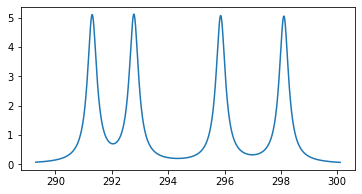

In [57]:
esca   = '''
C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
'''

# Create mol object and perform neutral SCF calculation
mol_esca = gto.Mole()
mol_esca.atom  = esca; mol_esca.basis = 'STO-3G'
mol_esca.build()
scf_esca = scf.UHF(mol_esca)
scf_esca.kernel()

# Perform core-hole calculation for each carbon atom (MOs 5-8) and append SCF IPs to a list
esca_ips = []
for i_mo in [5,6,7,8]:
    mo0 = copy.deepcopy(scf_esca.mo_coeff)
    occ0 = copy.deepcopy(scf_esca.mo_occ)
    occ0[0][i_mo] = 0.0
    ion_tmp = scf.UHF(mol_esca)
    scf.addons.mom_occ(ion_tmp, mo0, occ0)
    ion_tmp.kernel()
    esca_ips.append(au2ev*(ion_tmp.energy_tot() - scf_esca.energy_tot()))
    
# Broaden with a Lorentzian and plot
plt.figure(figsize=(6,3))
x,y = esca_ips,np.ones((len(esca_ips)))
# Call Lorentzian broadening with x-data, y-data, lower x-lim, upper x-lim, xstep, and broadening gamma
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4)
plt.plot(xi,yi); plt.show()

```{note}
There are some convergence issues, largely relating to the minimal basis set used. These issues disappear for more suitable basis set selections.
```

For illustration purposes, we also broaden with a gaussian (note that FWHM $= \gamma = 2\sqrt{2\ln{2}} \sigma$):

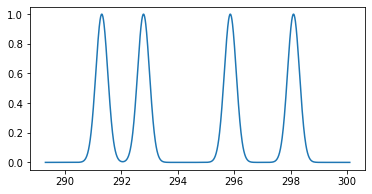

In [58]:
plt.figure(figsize=(6,3))
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.5/(2*np.sqrt(2*np.log(2))))
plt.plot(xi,yi); plt.show()

For the comparison to [experiment](https://doi.org/10.1016/j.elspec.2012.05.009) a cc-pVTZ basis set is selected, augmented with additional core-polarizing functions for the carbon atoms (i.e. cc-pCVTZ):


```{figure} ../img/xray/esca_xps.svg
---
name: esca_xps
---
X-ray photoemission of ESCA. Shifted by 0.11 eV and broadened by 0.3 eV.
```

The features originate in, from low to high energy: -CH$_3$, -CH$_2$-, -CO-, and CF$_3$. We note a good agreement for the first two features, but the comparison deteriorates for higher energies. This is largely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which HF is not capable of describing as well.

## X-ray absorption spectroscopy

In XAS the energy-dependent photoabsorption of the sample is measured, probing excitation of core electrons to bound or continuum states. These two different final states then provide information on unoccupied states and local chemical environment,r espectively, with a prototypical spectrum of a conjugated system as below: 


```{figure} ../img/xray/xafs.svg
---
name: xafs
---
Prototypical X-ray absorption spectrum of a conjugated system.
```

Above the spectrum we see the distinction of the various spectrum region, consisting of

- **XAFS (X-ray absorption fine structure):** consisting of excitations to both types of final states.

- **NEXAFS (near-edge X-ray absorption fine structure:** the region in which transitions to bound states is probed (this region is also known as XANES, X-ray absorption near-edge structure)

- **EXAFS (extended X-ray absorption fine structure):** which consists of transitions to continuum states, which is modulated by constructive or destructive interference between the emitted electron and the environment. This thus provide information on local chemical bonds.

Included in the illustraction is also the ionization potential, above which the oscillatory pattern due to interference with the environment is initiated, and assignment of typical features ($\pi^*$, Rydberg, and $\sigma^*$). Transitions to $\pi^*$ states are typically low in energy and very intense, and thus easy to identify. Rydberg states are typically weak and converge to the ionization potential. Transitions to $\sigma^*$ final states can be abive the ionization potential.


### Decoupling from valence continuum

A complication that arise when considering core excitations is the embedding of the core-excited states into the continuum of valence-ionized states. A number of approaches have been developed to remove this issue, including:

- The core-valence separation (CVS) approximation

- Restricted energy window, which share some with CVS

- CPP

- Real-time propagation

- 

Furthermore, approaches for constructing explicit excited states are available, 

In order to calculate 


```{figure} ../img/xray/cvs_adc.svg
---
name: cvs_adc
---
Global spectrum of water, using the 6-311G basis set. ADC(1) results resolving all 70 states in this basis.
```

Error of the CVS approach

### ADC eigenstates

References to CVS approach and CVS error.

In [34]:
struct  = gator.get_molecule(water)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)
adc_res = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=1)

SCF converged in 5 iterations.
Total Energy: -75.9838703827 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 6                                                           
                               CVS-ADC, Core Orbital Space  : 1                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                            

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.4139  291ms  [20.2703591  20.30081833 20.86977783 20.91121538 21.10647287 21.17210948]
  2    16       0.05362  600ms  [19.72495595 19.80691971 20.50881003 20.51569995 20.52445863 20.72564039]
  3    24      0.014469  700ms  [19.71673653 19.79707767 20.49577445 20.50503434 20.50804158 20.63850304]
  4    32      0.001267  833ms  [19.7163907  19.79671165 20.49373728 20.5048402  20.50629326 20.62964464]
  5    40    0.00011958   1.1s  [19.71637581 19.79669987 20.49353413 20.50482663 20.5061769  20.62883056]
=== Restart ===
  6    16    2.2907e-05  835ms  [19.7163753  19.79669916 20.49351327 20.5048247  20.50617017 20.62875659]
  7    24    8.2765e-06  842ms  [19.71637527 19.79669907 20.49350809 20.50482387 20.50616886 20.62873498]
  8    32    3.7389e-06   1.0s  [19.71637527 19.79669907 20.49350766 20.50482376 20.50616868 20.62872992]
  9    40     5.189e-07  959ms  [19.71637527 

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175    0.8001    0.1999  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
|  4      20.50617      558.0013   0.0881     0.835     0.165  |
|  5      20.62873      561.3363   0.0104    0.7926    0.2074  |
+--------------------------------------------------------------+

Using inbuilt routines:


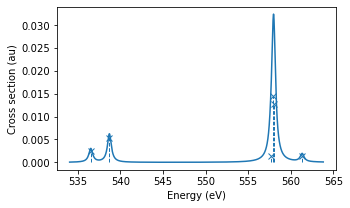

Or, constructing the spectra explicitly for the low-energy region:


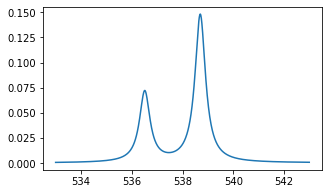

In [131]:
print(adc_res.describe())

print('Using inbuilt routines:')
plt.figure(figsize=(5,3))
adc_res.plot_spectrum()
plt.show()

print('Or, constructing the spectra explicitly for the low-energy region:')
plt.figure(figsize=(5,3))
x,y = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,533,543,0.01,0.5); plt.plot(xi,yi)
plt.show()

Compared to experiment with aug-cc-pCVTZ/cc-pVTZ (oxygen and hydrogen, respectively):


```{figure} ../img/xray/adc_water_xas.svg
---
name: adc_water_xas
---
CVS-ADC(2)-x versus experiment. Shifted by 0.37 and broadened by 0.4eV.
```


### TDDFT eigenstates

For discussion of self-interaction error - see [below](#self-interaction-error-in-dft).

### TDDFT damped response function

In [28]:
molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)
freqs = np.arange(514.0,525.0,0.1)/au2ev; freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev}
                                         ,method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0; sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

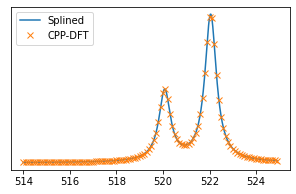

In [29]:
plt.figure(figsize=(5,3))
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x));plt.plot(au2ev*freqs,sigma,'x')
plt.yticks([]); plt.legend(('Splined','CPP-DFT'))
plt.show()

Using aug-cc-pCVTZ and compared to experiment


```{figure} ../img/xray/dft_water_xas.svg
---
name: dft_water_xas
---
CPP-DFT (B3LYP) versus experiment. DFT results shifted. FWHM 0.4 eV. Currently aug-cc-pVDZ - **change to aug-cc-pCVTZ/cc-pVTZ**.
```


```{note} 
this is a todo
```

plt.figure(figsize=(5,4)); plt.subplot(211)
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x));plt.plot(au2ev*freqs,sigma,'x')
plt.xlim((516,524)); plt.yticks([]); plt.legend(('Splined','CPP-DFT'))
plt.subplot(212)
data = np.loadtxt('../img/xray/water_xas.dat'); x,y = [],[]
for data_tmp in data: x.append(data_tmp[0]), y.append(data_tmp[1])
plt.plot(x,y); plt.xlim((531,539)); plt.yticks([]); plt.legend(('Experiment',''))
plt.show()

### Uracil in solution

CVS-ADC and CPP-DFT

1. Tailored CVS spaces

2. Gas phase

3. Polarizable embedding

### Maybe: massive system with DFT

## X-ray emission spectroscopy


- maybe illustration: Augen/fluorescent yield

### Decay from core-hole reference

Water (vs expt)

1. ADC(2)

2. TDDFT


In [47]:
mol = gto.Mole(); mol.atom  = water; mol.basis = '6-31G'; mol.build()
scfres = scf.UHF(mol); scfres.kernel()
mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
scfion = scf.UHF(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.kernel()
adc_xes = adcc.adc2(scfion, n_states=4)

converged SCF energy = -75.9838703827193  <S^2> = 6.3389294e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   2.6s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  445ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  450ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             3s 527ms


Using inbuilt functionalities, noticing the negative energies


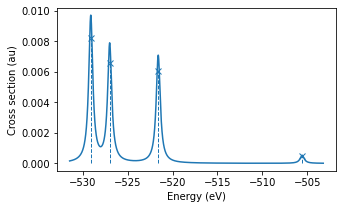

Flipping the x-axis and focusing on the high-energy features:


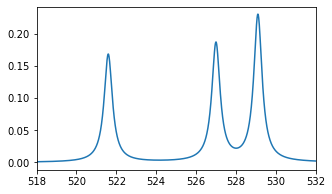

In [55]:
print('Using inbuilt functionalities, noticing the negative energies')

plt.figure(figsize=(5,3))
adc_xes.plot_spectrum()
plt.show()

print('Flipping the x-axis and focusing on the high-energy features:')

plt.figure(figsize=(5,3))
x,y = -au2ev*adc_xes.excitation_energy,adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((518,532))
plt.show()

Using cc-pCVTZ/cc-pVTZ and compared to experiment

```{figure} ../img/xray/adc_water_xes.svg
---
name: adc_water_xes
---
ADC(2) versus experiment. Shifted by 0.37 and broadened by 0.3 eV.
```

And for TDDFT

### Overlap model

Water (vs expt)

1. DFT

Energy from

\begin{equation}
\Delta E = \epsilon_v - \epsilon_c
\end{equation}


and intensities from

\begin{equation}
f \propto \left| \langle \phi_i \left| \hat{\mu} \right| \phi_c \rangle \right| ^2
\end{equation}

In [8]:
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)
orbital_energies = scf_drv.scf_tensors['E']
nocc = molecule.number_of_alpha_electrons()
print('Occupied orbital energies:',au2ev*orbital_energies[:nocc])

core = 0
overlap_energy = []
for virt in np.arange(nocc):
    if virt != core:
        overlap_energy.append(au2ev*(orbital_energies[virt]-orbital_energies[core]))

Occupied orbital energies: [-515.85  -272.492  -25.629  -12.769   -7.202   -7.202   -6.822]


Focusing on high-energy features


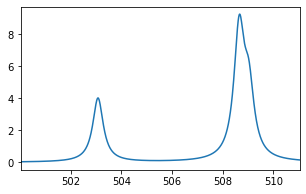

In [9]:
print('Focusing on high-energy features')

plt.figure(figsize=(5,3))
x,y = overlap_energy, np.ones((len(overlap_energy)))
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((max(overlap_energy)-9,max(overlap_energy)+2))
plt.show()

using cc-pCVTZ and compared to experiment


```{figure} ../img/xray//overlap_water_xes.svg
---
name: /overlap_water_xes
---
foo
```

plt.figure(figsize=(5,4)); plt.subplot(211)
x,y = overlap_energy, np.ones((len(overlap_energy)))
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((max(overlap_energy)-9,max(overlap_energy)+2)); plt.yticks([]); plt.legend(('DFT overlap',''))
plt.subplot(212)
data = np.loadtxt('../img/xray/water_xes.dat'); x,y = [],[]
for data_tmp in data: x.append(data_tmp[0]), y.append(data_tmp[1])
plt.plot(x,y); plt.xlim((518,529)); plt.yticks([]); plt.legend(('Experiment',''))
plt.show()

### Maybe: uracil in solution

1. Gas phase

2. Environment with PE

### Maybe valence-to-core XES

Suitable TM-complex with minimal static correlation

1. Overlap

2. TDDFT?

### Maybe: massive system with DFT

## Resonant inelastic X-ray scattering


Water.

1. 2-step model

2. DKH

## Coupling to molecular dynamics


Some system...

1. Dynamics + XAS

2. Dynamics + XES

3. Inclusion of environment?

4. Core-hole dynamics with some model?

## Analysis


### XAS

Vinylfluoride. CVS-ADC and CPP-DFT.

**First:** Calculate with CVS-ADC and CPP-DFT

In [32]:
vinyl   = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""

# SCF
struct  = gator.get_molecule(vinyl)
basis   = gator.get_molecular_basis(struct,'STO-3G')
scf_res = gator.run_scf(struct,basis)

# CVS space with three lowest
adc_full = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=10,core_orbitals=[1,2,3])

SCF converged in 5 iterations.
Total Energy: -174.5316847142 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 10                                                          
                               CVS-ADC, Core Orbital Space  : 1 2 3                                                       
                               Convergence threshold        : 1.0e-06                                                     
                                                                           

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Niter n_ss  max_residual  time  Ritz values
  1    18       0.66368  690ms  [10.796 10.861 11.058 11.07  11.103 11.175 11.256]
  2    36       0.20768  982ms  [10.536 10.617 10.818 10.858 10.923 10.99  11.008]
  3    54      0.063995   1.5s  [10.527 10.604 10.795 10.835 10.897 10.913 10.956]
  4    72      0.013737   2.3s  [10.526 10.603 10.794 10.834 10.896 10.906 10.95 ]
  5    90      0.045045   1.6s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
=== Restart ===
  6    36     0.0079751   1.4s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
  7    54     0.0013228   1.1s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
  8    72    0.00019889   1.3s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
  9    90    2.0341e-05   1.9s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
=== Restart ===
 10    36    2.6617e-06   1.3s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
 11    54    5.4338e-07   1.3s  [10.526 10.603 10.794 10.834 10.896 10.905 10.949]
=== Converg

In [ ]:
# CPP-DFT calculation. Note different energy. Comparison to expt below.


Discuss chemical shifts.

Now, lets look at various analysis tools.

Can study the amplitudes involved in adc calculations using the `state.describe_amplitudes` function, which takes as input `tolerance` which controls minimum amplitude to be printed, and the format using `index_format`, which takes three different forms. Splitting the resulting returning string according to `state` and printing the results for the first two states, we obtain:

#### Amplitudes

In [14]:
print('From \'hf\' format, which yield MO number:')
des_amp    = adc_full.describe_amplitudes(tolerance=0.1,index_format='hf')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])
print()

print('From \'adcc\' format, which indexing as used in adcc:')
des_amp    = adc_full.describe_amplitudes(tolerance=0.1,index_format='adcc')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])
print()


print('From \'homolumo\' format, which using HOMO/LUMO/HOCO format:')
des_amp    = adc_full.describe_amplitudes(tolerance=0.1,index_format='homolumo')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])

From 'hf' format, which yield MO number:
+-----------------------------------+
| State   1 ,      10.60328 au      |
+-----------------------------------+
|  1    -> 12     a ->a      -0.618 |
| 11  1 -> 12 12  ab->ab     +0.193 |
+-----------------------------------+
| State   2 ,      10.79376 au      |
+-----------------------------------+
|  2    -> 13     a ->a      -0.616 |
| 11  2 -> 12 13  ab->ab     -0.133 |
| 11  2 -> 12 13  aa->aa     -0.116 |

From 'adcc' format, which indexing as used in adcc:
+-------------------------------------------------------+
| State   1 ,      10.60328 au,      288.5301 eV        |
+-------------------------------------------------------+
| (o2  1)         -> (v1  0)          a ->a      -0.618 |
| (o1  8) (o2  1) -> (v1  0) (v1  0)  ab->ab     +0.193 |
+-------------------------------------------------------+
| State   2 ,      10.79376 au,      293.7132 eV        |
+-------------------------------------------------------+
| (o2  2)         -> (v1

#### Atomic contributions

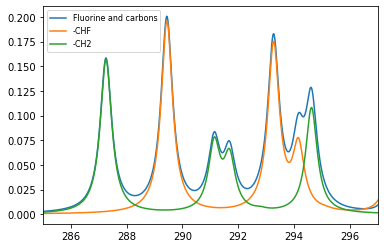

In [230]:
# ADC space discussion elsewhere
'''
plt.figure(figsize=(6,4))
x,y = au2ev*adc_full.excitation_energy, adc_full.oscillator_strength
xi,yi = lorentzian(x,y,285,300,0.01,0.5); plt.plot(xi,yi)
x,y = au2ev*adc_chf.excitation_energy, adc_chf.oscillator_strength
xi,yi = lorentzian(x,y,285,300,0.01,0.5); plt.plot(xi,yi)
x,y = au2ev*adc_ch2.excitation_energy, adc_ch2.oscillator_strength
xi,yi = lorentzian(x,y,285,300,0.01,0.5); plt.plot(xi,yi)
plt.legend(('Fluorine and carbons','-CHF','-CH2'),loc='upper left',fontsize=8)
plt.xlim((285,297))
plt.show()
'''

In [35]:
adc_chf = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=4,core_orbitals=[2])
adc_ch2 = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=4,core_orbitals=[3])

                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 4                                                           
                               CVS-ADC, Core Orbital Space  : 2                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                                                                          
Starting cvs-adc

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)



  1     6       0.32663  136ms  [10.861 11.059 11.176 11.381]
  2    12       0.10666  205ms  [10.617 10.858 11.008 11.235]
  3    18      0.051857  200ms  [10.604 10.835 10.957 11.14 ]
  4    24     0.0097457  293ms  [10.603 10.834 10.95  11.065]
  5    30      0.003439  318ms  [10.603 10.834 10.949 11.05 ]
=== Restart ===
  6    12     0.0032205  270ms  [10.603 10.834 10.949 11.044]
  7    18     0.0029367  190ms  [10.603 10.834 10.949 11.037]
  8    24    0.00095608  258ms  [10.603 10.834 10.949 11.034]
  9    30    0.00029649  248ms  [10.603 10.834 10.949 11.032]
=== Restart ===
 10    12    8.6485e-05  305ms  [10.603 10.834 10.949 11.032]
 11    18    0.00010066  235ms  [10.603 10.834 10.949 11.031]
 12    24    2.9719e-05  319ms  [10.603 10.834 10.949 11.031]
 13    30    6.9235e-06  303ms  [10.603 10.834 10.949 11.031]
=== Restart ===
 14    12    1.4935e-06  249ms  [10.603 10.834 10.949 11.031]
 15    18    4.4223e-07  215ms  [10.603 10.834 10.949 11.031]
=== Converged ===
   

Resolving core contributions using different eigenstates


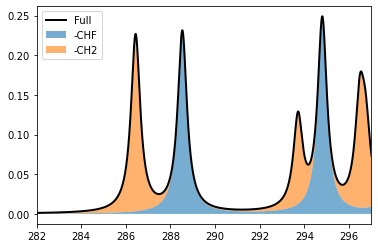

In [38]:
print('Resolving core contributions using different eigenstates')
plt.figure(figsize=(6,4))
x1,y1 = au2ev*adc_chf.excitation_energy, adc_chf.oscillator_strength
x1i,y1i = lorentzian(x1,y1,280,300,0.01,0.5)
x2,y2 = au2ev*adc_ch2.excitation_energy, adc_ch2.oscillator_strength
x2i,y2i = lorentzian(x2,y2,280,300,0.01,0.5)
plt.plot(x2i,y1i+y2i,'k-',linewidth=2.0)
plt.fill_between(x2i, 0, y1i,alpha=0.6)
plt.fill_between(x2i, y1i, y1i+y2i,alpha=0.6)
plt.legend(('Full','-CHF','-CH2'))
plt.xlim((282,297))
plt.show()

In [15]:



print('MAYBE: the same using the full-space eigenvectors')
print('Compare these two approaches!')

print('Could come from looking more into the eigenstates, or by just splitting the describe_amplitude results...')

MAYBE: the same using the full-space eigenvectors
Compare these two approaches!
Could come from looking more into the eigenstates, or by just splitting the describe_amplitude results...


In [52]:
molecule = vlx.Molecule.read_str(vinyl, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "STO-3G")
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)
freqs = np.arange(270.0,282.0,0.25)/au2ev; freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev}
                                         ,method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0; sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)


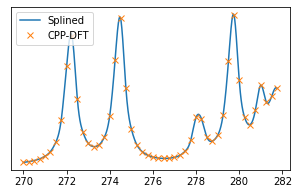

In [53]:
plt.figure(figsize=(5,3))
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x));plt.plot(au2ev*freqs,sigma,'x')
plt.yticks([]); plt.legend(('Splined','CPP-DFT'))
plt.show()

In [49]:
nocc = molecule.number_of_alpha_electrons()
nvirt = scf_drv.mol_orbs.number_mos() - nocc
spec_comp = []
solution_vecs = cpp_prop.get_property('solutions')
x_solution,y_solution,z_solution = [],[],[]
for w in freqs:
    x_solution.append(solution_vecs[('x',w)]); y_solution.append(solution_vecs[('y',w)]); z_solution.append(solution_vecs[('z',w)])
x_solution,x_solution,x_solution = np.array(x_solution),np.array(y_solution),np.array(z_solution)
for occ in np.arange(0,nocc): spec_comp.append([])
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(0,nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sX[i]+comp_Y*sY[i]+comp_Z*sZ[i]))
plt.figure(figsize=(8,3))
mo1     = np.array(spec_comp[0])
mo2     = np.array(spec_comp[1])
mo_rest = spec_comp[2]
for i in np.arange(2,len(spec_comp)):
    for j in np.arange(len(spec_comp[0])):
        mo_rest[j] += spec_comp[i][j]

        
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y1    = interp1d(au2ev*freqs, mo1, kind='cubic')
yrest = interp1d(au2ev*freqs, mo_rest, kind='cubic')
plt.plot(x,y1(x)+yrest(x),'k-',linewidth=2)
plt.fill_between(x, yrest(x), y1(x)+yrest(x), alpha=0.6)
plt.fill_between(x, 0, yrest(x), alpha=0.6)
plt.legend(('Total','MO #1','Rest'))
plt.tight_layout()

IndexError: list index out of range

We see that

- The first two states corresponds to transitions from two different MOs, which here corresponds to CHF and CH2

- The transitions are dominated to two different virtuals

#### Polarization

Polarization


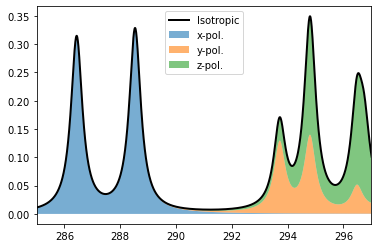

In [51]:
print('Polarization')
prefactor = 1.
sX,sY,sZ = [],[],[]
freq = adc_full.excitation_energy
for i in np.arange(len(freq)):
    tmp_tms = adc_full.transition_dipole_moment[i]
    sX.append(freqs[i]*tmp_tms[0]**2)
    sY.append(freqs[i]*tmp_tms[1]**2)
    sZ.append(freqs[i]*tmp_tms[2]**2)
    
plt.figure()
x,y = au2ev*freq, sX
xX,yX = lorentzian(x,y,285,300,0.01,0.5)
x,y = au2ev*freq, sY
xY,yY = lorentzian(x,y,285,300,0.01,0.5)
x,y = au2ev*freq, sZ
xZ,yZ = lorentzian(x,y,285,300,0.01,0.5)
plt.plot(xX,yX+yY+yZ,'k-',linewidth=2)
plt.fill_between(xX, 0, yX,alpha=0.6)
plt.fill_between(xX, yX, yX+yY,alpha=0.6)
plt.fill_between(xX, yX+yY, yX+yY+yZ,alpha=0.6)
plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'))
plt.xlim((285,297))
plt.show()

This can be done for CPP-DFT, taking the water calculation from above as an example.

Polarization:

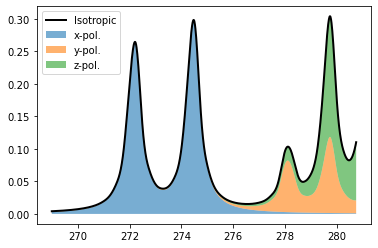

In [50]:
sX,sY,sZ = [],[],[]
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    sX.append(4.0 * np.pi * w * axx / 137.035999 / 3.0)
    sY.append(4.0 * np.pi * w * ayy / 137.035999 / 3.0)
    sZ.append(4.0 * np.pi * w * azz / 137.035999 / 3.0)

x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
yX = interp1d(au2ev*freqs, sX, kind='cubic')
yY = interp1d(au2ev*freqs, sY, kind='cubic')
yZ = interp1d(au2ev*freqs, sZ, kind='cubic')
plt.plot(x,yX(x)+yY(x)+yZ(x),'k-',linewidth=2)
plt.fill_between(x, 0, yX(x), alpha=0.6)
plt.fill_between(x, yX(x), yX(x)+yY(x), alpha=0.6)
plt.fill_between(x, yX(x)+yY(x), yX(x)+yY(x)+yZ(x), alpha=0.6)
plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'))
plt.show()

And atomic:

...which is of course only one atom...

The decomposition for vinylfluoride yields

#### Comparison between ADC and DFT

One figure - ADC and TDDFT, atomic and polarization


```{figure} ../img/xray/vinyl_decomp.svg
---
name: vinyl_decomp
---
foo
```

Visualization and descriptors (?)

## Self-interaction error in DFT

For a single-electron systems the following equality should hold for the two-electron terms:

$$
J[\rho] + E_{xc} [\rho] = 0.0
$$

This cancellation is achieved for, e.g. Hartree–Fock theory, but for any approximate functionals in DFT it will instead result in an erronous contribution to the energy. DFT-based methods generally suffer from self-interaction error (SIE), which corresponds to the sum of Coulomb and exchange self-interactions that remain because of the use of approximate exchange functionals. In more detail, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree--Fock theory, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional.

- Radial distribution or something for functionals? Calculate error?

## Relativity

Total relativistic and correlation corrections as a function of Z

### Scalar relativistic effects

#### Shift in IP

In [69]:
z, rel_mo, rel_delta = [],[],[]
for i in np.arange(2,20,2):
    struct = str(i)+'   0.0  0.0  0.0'
    mol = gto.Mole(); mol.atom  = struct; mol.basis = 'unc-ccpvdz'; mol.build()
    scf_nr  = scf.UHF(mol); scf_nr.kernel()
    scf_rel = scf.UHF(mol).x2c1e(); scf_rel.kernel()
    z.append(i)
    rel_mo.append(27.2114*(scf_nr.mo_energy[0][0]-scf_rel.mo_energy[0][0]))
    mo0 = copy.deepcopy(scf_nr.mo_coeff); occ0 = copy.deepcopy(scf_nr.mo_occ); occ0[0][0] = 0.0
    ion_nr  = scf.UHF(mol); scf.addons.mom_occ(ion_nr, mo0, occ0);  ion_nr.kernel()
    ion_rel = scf.UHF(mol).x2c1e();     scf.addons.mom_occ(ion_rel, mo0, occ0);     ion_rel.kernel()
    rel_delta.append(27.2114*((ion_rel.e_tot-scf_rel.e_tot)-(ion_nr.e_tot-scf_nr.e_tot)))

converged SCF energy = -2.85516047724517  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -2.85525304501806  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -1.99426858617921  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -1.99436880481929  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -14.5723376313364  <S^2> = -1.3322676e-15  2S+1 = 1
converged SCF energy = -14.5748455751004  <S^2> = -1.7763568e-15  2S+1 = 1
converged SCF energy = -10.0357274640245  <S^2> = 0.75629212  2S+1 = 2.0062823
converged SCF energy = -10.0378218682236  <S^2> = 0.75630468  2S+1 = 2.0062948
converged SCF energy = -37.596291563267  <S^2> = 0  2S+1 = 1
converged SCF energy = -37.6112425609769  <S^2> = 1.7763568e-15  2S+1 = 1
converged SCF energy = -26.6586016324337  <S^2> = 0.75725115  2S+1 = 2.0072381
converged SCF energy = -26.6699783724446  <S^2> = 0.75726738  2S+1 = 2.0072542
converged SCF energy = -74.665428938125  <S^2> = 4.4408921e-16  2S+1 = 1
converged SCF energy = -74.717502069482  <S^2> 

yielding

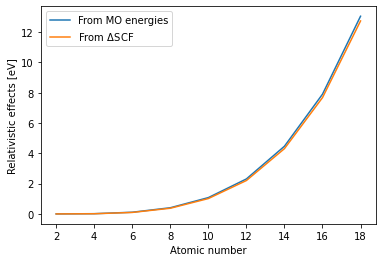

In [71]:
plt.figure(figsize=(6,4))
plt.plot(z,rel_mo)
plt.plot(z,rel_delta)
plt.legend(('From MO energies',r'From $\Delta$SCF'))
plt.xlabel('Atomic number')
plt.ylabel('Relativistic effects [eV]')
plt.show()

#### Shift in XAS

In [87]:
mol = gto.Mole()
mol.atom  = water; mol.basis = 'unc-6-31G'
mol.build()

# non-relativistic
scf_nr  = scf.RHF(mol); scf_nr.kernel()
adc_nr  = adcc.cvs_adc2(scf_nr,n_singlets=5,core_orbitals=1)

# relativistic
scf_rel = scf.RHF(mol).x2c1e(); scf_rel.kernel()
adc_rel = adcc.cvs_adc2(scf_rel,n_singlets=5,core_orbitals=1)

converged SCF energy = -75.9890271783229


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7777  640ms  [20.276 20.312 20.861 20.922 20.93 ]
  2    20      0.035824  561ms  [19.729 19.811 20.31  20.405 20.498]
  3    30    4.1402e-05  581ms  [19.724 19.807 20.306 20.4   20.498]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             1s 818ms
converged SCF energy = -76.0403950942686
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7842  505ms  [20.29  20.327 20.876 20.937 20.945]
  2    20      0.036027  537ms  [19.743 19.825 20.325 20.419 20.513]
  3    30    4.1677e-05  648ms  [19.738 19.821 20.32  20.414 20.512]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             1s 746ms


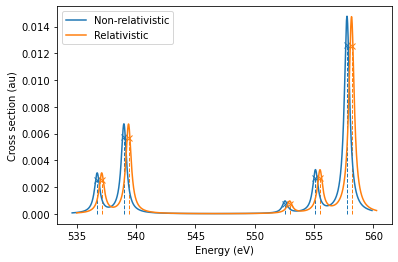

Energy shift of the first feature: 0.38 eV


In [91]:
plt.figure()
adc_nr.plot_spectrum(label='Non-relativistic')
adc_rel.plot_spectrum(label='Relativistic')
plt.legend(); plt.show()
print('Energy shift of the first feature:',
      np.around(au2ev*(adc_rel.excitation_energy[0]-adc_nr.excitation_energy[0]),2),'eV')

#### Shift in XES

In [98]:
mol = gto.Mole()
mol.atom  = water; mol.basis = 'unc-6-31G'
mol.build()

# non-relativistic
scf_nr  = scf.UHF(mol); scf_nr.kernel()
mo0 = copy.deepcopy(scf_nr.mo_coeff)
occ0 = copy.deepcopy(scf_nr.mo_occ)
occ0[0][0] = 0.0
ion_nr = scf.UHF(mol); scf.addons.mom_occ(ion_nr, mo0, occ0); ion_nr.kernel()
adc_nr  = adcc.adc2(ion_nr,n_states=4)

# relativistic (can reuse the non-relativistic SCF start)
ion_rel = scf.UHF(mol).x2c1e(); scf.addons.mom_occ(ion_rel, mo0, occ0); ion_rel.kernel()
adc_rel = adcc.adc2(ion_rel,n_states=4)

converged SCF energy = -75.9890271783204  <S^2> = 8.9066532e-12  2S+1 = 1
converged SCF energy = -56.1707263747173  <S^2> = 0.76785148  2S+1 = 2.0177725


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        7.5126   2.1s  [-19.076 -18.983 -18.741 -18.153]
  2    16      0.045812  386ms  [-19.393 -19.319 -19.131 -18.544]
  3    24    2.6332e-05  366ms  [-19.394 -19.32  -19.133 -18.546]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             2s 861ms
converged SCF energy = -56.2081331115692  <S^2> = 0.76789584  2S+1 = 2.0178165
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        7.5482   2.1s  [-19.09  -18.996 -18.754 -18.165]
  2    16      0.046112  601ms  [-19.407 -19.333 -19.146 -18.557]
  3    24    2.6698e-05  425ms  [-19.408 -19.334 -19.147 -18.558]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             3s 177ms


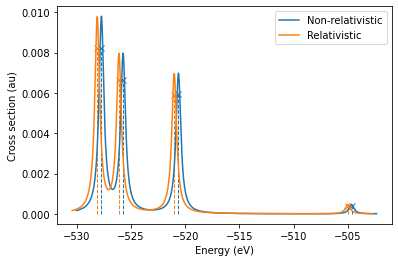

Energy shift of the first feature: 0.39 eV


In [100]:
plt.figure()
adc_nr.plot_spectrum(label='Non-relativistic')
adc_rel.plot_spectrum(label='Relativistic')
plt.legend(); plt.show()
print('Energy shift of the first feature:',
      np.around(np.abs(au2ev*(adc_rel.excitation_energy[0]-adc_nr.excitation_energy[0])),2),'eV')

### Spin-orbit coupling

## Relaxation

### In ADC


### In TDDFT


1. Radial distribution: Z, Z with hole, Z+1

2. Total density: formaldehyde

3. Maybe: visualization of effects for XAS and XES


```{figure} ../img/xray/relax_form.svg
---
name: relax_form
---
foo
```

## Basis set considerations

The basis set requirements of X-ray spectrum calculations will depend strongly on which spectroscopy

- XPS and XES probes occupied states, and thus need a good description of those

- XAS and RIXS probes excited states, and thus need an improved description also of this region

However, in both cases the relaxation due to the creation of a core-hole need to be enabled, which yield requirements of reasonable flexibility of the core and inner valence region. This is not typically the case, as most studies deals with valence electron and thus have a minimal or close to minimal description of the core region.

A number of approaches for improving the basis sets have been developed:

1. Augment the Dunning basis sets with core-polarizing functions, e.g. cc-pV*n*Z $\rightarrow$ cc-pCV*n*Z

2. Adding extra flexibility by performing full or partial decontraction, e.g.
    1. u6-311++G** is 6-311++G** with decontracted 1s function of the probed element
    2. un-6-311++G** is a fully decontracted 6-311++G** basis set

3. Use basis functions from the next element, is inspired by the equvalent core/Z+1 approximation

Here we focus on the basis set effects for calculations of the IP of water, and we encourage the interested reader to do the same excercise for XES, as well as for XAS (where the augmentation of diffuse functions also need to be considered).

In [79]:
u6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
un6311gss = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                1.000000               1.000000
O    SP
      9.628370               1.000000               1.000000
O    SP
      2.853320               1.000000               1.000000
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
z6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  0.00189515
   1297.230                  0.0143859
    299.2960                 0.0707320
     87.37710                0.2400010
     25.67890                0.5947970
      3.740040               0.2808020
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
O    S
  11427.10                   0.00180093
   1722.350                  0.0137419
    395.7460                 0.0681334
    115.1390                 0.2333250
     33.60260                0.5890860
      4.919010               0.2995050
O    SP
     55.44410                0.114536               0.0354609
     12.63230                0.920512               0.237451
      3.717560              -0.00337804             0.820458
O    SP
      1.165450               1.000000               1.000000
O    SP
      0.321892               1.000000               1.000000
O    D
      1.750                  1.000000
'''), 'H': '6-311G**'}

Exotic version of basis sets found above

```python
basis_sets = ['6-311G**',u6311gss,un6311gss,z6311gss, 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
ip_hf, ip_mp2, ip_ccsd, ip_b3lyp, n_bas = [],[],[],[],[]
for basis in basis_sets:
    mol = gto.Mole(); mol.atom  = water; mol.basis = basis
    mol.build()
    scfres = scf.UHF(mol); scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UHF(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.kernel()
    ip_hf.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    ccsd_res = cc.UCCSD(scfres).run(); ccsd_ion = cc.UCCSD(scfion).run(max_cycle=500)
    ip_ccsd.append(au2ev*(ccsd_ion.e_tot - ccsd_res.e_tot))
    ip_mp2.append(au2ev*(ccsd_ion.e_hf+ccsd_ion.emp2-(ccsd_res.e_hf+ccsd_res.emp2)))
    scfres = scf.UKS(mol); scfres.xc = 'b3lyp'; scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UKS(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.xc = 'b3lyp'; scfion.kernel()
    ip_b3lyp.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    n_bas.append(len(scfres.mo_occ[0]))
    
plt.figure(figsize=(10,5))
basis_set_labels = ['6-311G**','u6-311G**','un6-311G**','6-311G** (Z+1)', 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
plt.plot(n_bas,ip_hf,'r*'); plt.plot(n_bas,ip_mp2,'bv')
plt.plot(n_bas,ip_ccsd,'d',color='orange'); plt.plot(n_bas,ip_b3lyp,'go')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9,539.9],'k:')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9-0.3,539.9-0.3],'k--')
plt.xlim((min(n_bas)-5,max(n_bas)+5))
plt.ylabel('Ionization potential [eV]')
plt.legend(('HF','MP2','CCSD','B3LYP','Expt','Expt - 0.3 eV'))
plt.xticks(n_bas,basis_set_labels,rotation=70,fontsize=10)
plt.tight_layout(); plt.savefig('basis_xps.svg')
plt.show()
```

The execution of which yields



```{figure} ../img/xray/basis_xps.svg
---
name: basis_xps
---
foo
```

On the y-axis we see the basis set labels, with order and position determined by the number of basis functions.

We see that...

## Notes
```{margin} An optional title
My margin content
```

```{note}
**Not included (yet)**
- SO-coupling
- beyond electrinc-dipole approximation
- multireference methods
```

In [7]:
import veloxchem as vlx

mol_str = """
C        0.00000000    0.00000000    0.00000000
O        0.00000000    0.00000000    1.43
"""
molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis = vlx.MolecularBasis.read(molecule, "sto-3g")

scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_drv.compute(molecule, basis)

C = scf_drv.scf_tensors['C']

S = scf_drv.scf_tensors['S']
print('Overlap matrix:\n', S)

# not available
#print('Available basis sets for carbon:\n', vlx.MolecularBasis.get_avail_basis('C'))

kin_drv = vlx.KineticEnergyIntegralsDriver()
T_ao = kin_drv.compute(molecule, basis).to_numpy()
T = np.einsum('ai, ab, bj -> ij', C, T_ao, C)

npot_drv = vlx.NuclearPotentialIntegralsDriver()
V_ao = -npot_drv.compute(molecule, basis).to_numpy()
V = np.einsum('ai, ab, bj -> ij', C, V_ao, C)

# core Hamiltonian
h = T + V

h_aver = 2 * np.einsum('ii', h[:nocc,:nocc])
print('Expectation value of one-electron Hamiltonian:', h_aver)

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. veloxchem.veloxchemlib.KineticEnergyIntegralsDriver(arg0: object)

Invoked with: 